PACKAGES

In [1]:
from deepod.models.tabular import DevNet, PReNet, DeepSAD, FeaWAD, RoSAS
from deepod.metrics import tabular_metrics
from autoencodernn import *
from tapnet import *

/home/work/anaconda3/envs/dongjae_rba/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle
import os
from datetime import datetime

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score

DATASET

In [5]:
dfs = []
for filename in tqdm(os.listdir('./data/')):
    if 'preprocessed' in filename:
        dfs.append(pd.read_csv(f'./data/{filename}', index_col = 0))
df = pd.concat(dfs).reset_index(drop = True)
del(dfs)

In [6]:
train_valid_df, test_df = train_test_split(df, test_size = 0.2, stratify = df['label'])
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.125, stratify = train_valid_df['label'])

In [7]:
X_train = train_df.drop(['label'], axis = 1)
y_train = train_df['label']

X_valid = valid_df.drop(['label'], axis = 1)
y_valid = valid_df['label']

X_test = test_df.drop(['label'], axis = 1)
y_test = test_df['label']

In [8]:
X_train.to_csv('./checkpoint/x_train.csv')
y_train.to_csv('./checkpoint/y_train.csv')

X_valid.to_csv('./checkpoint/x_valid.csv')
y_valid.to_csv('./checkpoint/y_valid.csv')

X_test.to_csv('./checkpoint/x_test.csv')
y_test.to_csv('./checkpoint/y_test.csv')

In [9]:
# with open('./checkpoint/anomaly_models.pkl', 'rb') as f:
#     models = pickle.load(f)

In [10]:
# train_df = pd.read_csv('./checkpoint/train_df.csv', index_col = 0)
# valid_df = pd.read_csv('./checkpoint/valid_df.csv', index_col = 0)
# test_df = pd.read_csv('./checkpoint/test_df.csv', index_col = 0)

In [11]:
# X_train = pd.read_csv('./checkpoint/x_train.csv')
# y_train = pd.read_csv('./checkpoint/y_train.csv')

# X_valid = pd.read_csv('./checkpoint/x_valid.csv')
# y_valid = pd.read_csv('./checkpoint/y_valid.csv')

# X_test = pd.read_csv('./checkpoint/x_test.csv')
# y_test = pd.read_csv('./checkpoint/y_test.csv')

MODEL

In [12]:
models = []

In [13]:
def anomaly_preprocessing(df1, df2, df3):
    df1['type'] = 'train'
    df2['type'] = 'valid'
    df3['type'] = 'test'

    df = pd.concat([df1, df2, df3]).reset_index(drop = True)

    country_onehot = pd.get_dummies(df['country']).astype(int)
    risk_grades = df[['region_risk_grade', 'city_risk_grade', 'name_risk_grade']]
    browser_onehot = pd.get_dummies(df['browser_name']).astype(int)
    os_onehot = pd.get_dummies(df['os_name']).astype(int)
    legacys = df[['browser_is_legacy', 'os_is_legacy']]
    device_types = pd.get_dummies(df['device_type']).astype(int)
    rtts = df['rtt']
    type = df['type']
    label = df['label']
    df = pd.concat([country_onehot, risk_grades, browser_onehot, os_onehot, legacys, device_types, rtts, type, label], axis = 1)

    df1 = df[df['type'] == 'train'].drop('type', axis = 1)
    df2 = df[df['type'] == 'valid'].drop('type', axis = 1)
    df3 = df[df['type'] == 'test'].drop('type', axis = 1)

    return df1, df2, df3

In [14]:
# Anomaly Detection
print('Anomaly Detection Model')
ad_model_names = ['DevNet', 'PReNet', 'DeepSAD', 'FeaWAD', 'RoSAS']
ad_models = [
    # DevNet(),           # 86.5s
    # PReNet(),           # Too long. (2.4 hours)
    DeepSAD(epochs = 50),          # 75.4s
    # FeaWAD(epochs = 10000, lr = 0.01),           # Very fast but poor.
    # RoSAS(),            # Too long.
]

train_df_ad, valid_df_ad, test_df_ad = anomaly_preprocessing(train_df, valid_df, test_df)

X_train_ad = train_df_ad.drop(['label'], axis = 1)
y_train_ad = train_df_ad['label']

X_valid_ad = valid_df_ad.drop(['label'], axis = 1)
y_valid_ad = valid_df_ad['label']

X_test_ad = test_df_ad.drop(['label'], axis = 1)
y_test_ad = test_df_ad['label']

for model_name, model in zip(ad_model_names, ad_models):
    print('start -', datetime.now())
    
    model.fit(X_train_ad.to_numpy(), y_train_ad.to_numpy())
    print('Train Finish')
    pred_train = (model.decision_function(X_train_ad.to_numpy()) > 0.5).astype(int)
    auc_train, ap_train, f1_train = tabular_metrics(y_train_ad, pred_train)
    
    pred_valid = (model.decision_function(X_valid_ad.to_numpy()) > 0.5).astype(int)
    auc_valid, ap_valid, f1_valid = tabular_metrics(y_valid_ad, pred_valid)
    
    print(f'Trained with {model}')
    print(f'Train - AUC: {auc_train}, AP: {ap_train}, F1: {f1_train}')
    print(f'Valid - AUC: {auc_valid}, AP: {ap_valid}, F1: {f1_valid}')

    models.append(model)
    print('end -', datetime.now(), '\n')

In [16]:
# NOTE: For faster execution, use this cell and comment the upper one.
# with open('./checkpoint/deepsad.pkl', 'rb') as f:
#     deepsad_model = pickle.load(f)[0]

In [17]:
# AutoEncoder + NN
print('AutoEncoder + NN Model')
autoencoder_nn_model = model_v2(
    train_data = train_df,          # Train set
    valid_data = valid_df,          # Validation set
    test_data = test_df,            # Test set
    criteria = 0.5,                 # Classification threshold
    split_ratio = [7, 1, 2],        # split ratio (format: [train,validation,test])
    autoencoder_epochs = 50,        # epochs of autoencoder
    classifier_epochs = 200,        # epochs of classifier
    weight_for_attack = 15,         # weight for attack
)

models.append(autoencoder_nn_model)

In [18]:
# NOTE: For faster execution, use this cell and comment the upper one.
# with open('./checkpoint/autoencoder_nn.pkl', 'rb') as f:
#     autoencoder_nn_model = pickle.load(f)[0]

In [19]:
# TabNet
print('TabNet Model')
selected_columns = ['country_code', 'region', 'city_risk_grade', 'name_risk_grade', 'login_success', 'browser_is_legacy', 'os_is_legacy', 'rtt', 'device_type', 'label']
categorical_columns = ['country_code', 'device_type', 'region']

tabnet_model = TabNetModel(train_df, valid_df, test_df, selected_columns, categorical_columns, 'label')         #, pre_train_epochs = 5, epochs = 5)
models.append(tabnet_model)

In [20]:
# NOTE: For faster execution, use this cell and comment the upper one.
# with open('./checkpoint/tabnet.pkl', 'rb') as f:
#     tabnet_model = pickle.load(f)[0]

In [21]:
tabnet_soft = tabnet_model.clf.predict_proba(tabnet_model.X_test.values)[:, 1]

In [22]:
anomaly_pred = (deepsad_model.decision_function(X_test_ad.to_numpy()) > 0.5).astype(int)

testing: 100%|██████████| 4758/4758 [00:16<00:00, 294.78it/s]


In [23]:
print(classification_report(y_test['label'].to_numpy(), anomaly_pred))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    277642
           1       0.26      0.89      0.41     26867

    accuracy                           0.77    304509
   macro avg       0.63      0.83      0.63    304509
weighted avg       0.92      0.77      0.82    304509



In [24]:
print(accuracy_score(y_test['label'].to_numpy(), anomaly_pred))
print(precision_score(y_test['label'].to_numpy(), anomaly_pred))
print(recall_score(y_test['label'].to_numpy(), anomaly_pred))
print(f1_score(y_test['label'].to_numpy(), anomaly_pred))
print(geometric_mean_score(y_test['label'].to_numpy(), anomaly_pred))

0.7709164589552361
0.26416671248694124
0.894108013548219
0.4078368788305801
0.8237862991451318


In [25]:
an_df = autoencoder_nn_model.predicted_df
autonn_pred = an_df['Predicted Label'].to_numpy().astype(int)
print(classification_report(an_df['Actual Label'], an_df['Predicted Label']))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    277642
         1.0       0.88      0.47      0.61     26867

    accuracy                           0.95    304509
   macro avg       0.91      0.73      0.79    304509
weighted avg       0.94      0.95      0.94    304509



In [26]:
print(accuracy_score(an_df['Actual Label'].to_numpy(), autonn_pred))
print(precision_score(an_df['Actual Label'].to_numpy(), autonn_pred))
print(recall_score(an_df['Actual Label'].to_numpy(), autonn_pred))
print(f1_score(an_df['Actual Label'].to_numpy(), autonn_pred))
print(geometric_mean_score(an_df['Actual Label'].to_numpy(), autonn_pred))

0.9477223990095531
0.8782476506357103
0.47307105370901104
0.6149156970415346
0.6856156371469659


In [27]:
# tabnet_pred = tabnet_model.clf.predict(tabnet_model.X_test.values)
tabnet_pred = tabnet_soft > 0.5
print(classification_report(tabnet_model.y_test, tabnet_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97    277642
           1       0.65      0.69      0.67     26867

    accuracy                           0.94    304509
   macro avg       0.81      0.83      0.82    304509
weighted avg       0.94      0.94      0.94    304509



In [28]:
print(classification_report(tabnet_model.y_test, tabnet_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97    277642
           1       0.65      0.69      0.67     26867

    accuracy                           0.94    304509
   macro avg       0.81      0.83      0.82    304509
weighted avg       0.94      0.94      0.94    304509



In [29]:
print(accuracy_score(y_test['label'].to_numpy(), tabnet_pred))
print(precision_score(y_test['label'].to_numpy(), tabnet_pred))
print(recall_score(y_test['label'].to_numpy(), tabnet_pred))
print(f1_score(y_test['label'].to_numpy(), tabnet_pred))
print(geometric_mean_score(y_test['label'].to_numpy(), tabnet_pred))

0.9403400227907878
0.6532121724429417
0.6902892023672162
0.671239074177962
0.815971520181864


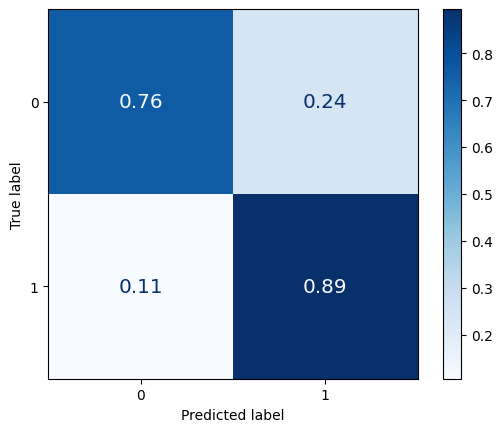

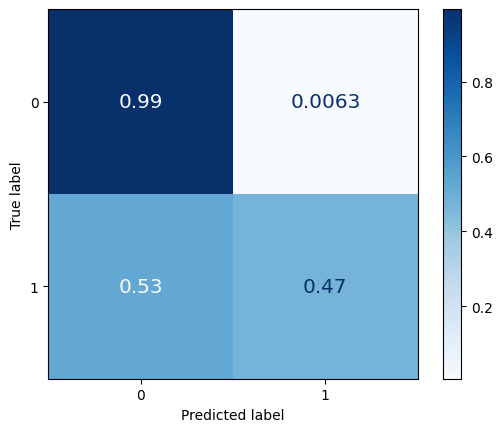

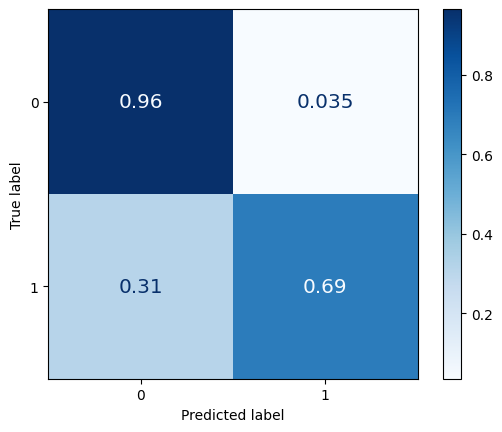

In [30]:
disp1 = ConfusionMatrixDisplay.from_predictions(y_test['label'].to_numpy(), anomaly_pred, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'})
disp2 = ConfusionMatrixDisplay.from_predictions(an_df['Actual Label'].astype(int), an_df['Predicted Label'].astype(int), normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'})
disp3 = ConfusionMatrixDisplay.from_predictions(tabnet_model.y_test, tabnet_pred, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'})

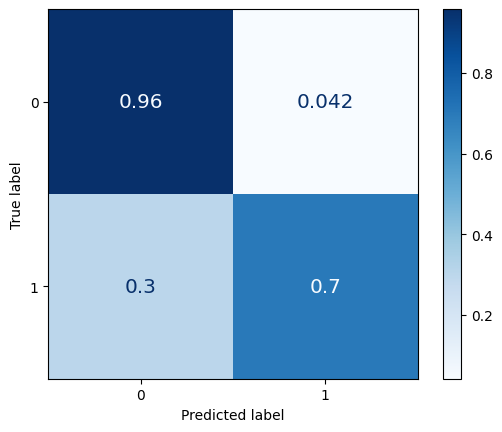

In [31]:
# Majority Voting
majority_pred = (np.stack([anomaly_pred, autonn_pred, tabnet_pred]).mean(axis = 0) > 0.5).astype(int)
majority_disp = ConfusionMatrixDisplay.from_predictions(y_test['label'].to_numpy(), majority_pred, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'})

In [32]:
print(accuracy_score(y_test['label'].to_numpy(), majority_pred))
print(precision_score(y_test['label'].to_numpy(), majority_pred))
print(recall_score(y_test['label'].to_numpy(), majority_pred))
print(f1_score(y_test['label'].to_numpy(), majority_pred))
print(geometric_mean_score(y_test['label'].to_numpy(), majority_pred))

0.9354403318128528
0.6185916419874958
0.6997059589831391
0.6566533349634106
0.8188373648726113


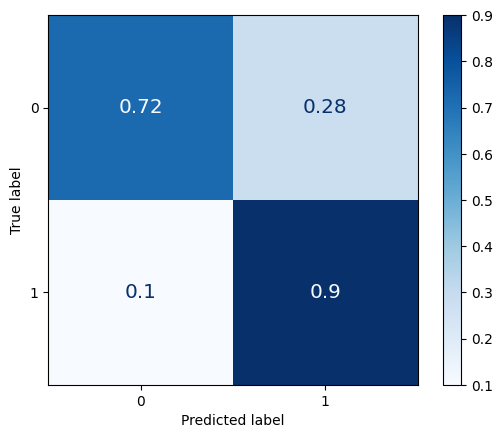

In [33]:
# Or Voting
or_pred = (np.stack([anomaly_pred, autonn_pred, tabnet_pred]).sum(axis = 0) != 0).astype(int)
or_disp = ConfusionMatrixDisplay.from_predictions(y_test['label'].to_numpy(), or_pred, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'})

In [34]:
print(accuracy_score(y_test['label'].to_numpy(), or_pred))
print(precision_score(y_test['label'].to_numpy(), or_pred))
print(recall_score(y_test['label'].to_numpy(), or_pred))
print(f1_score(y_test['label'].to_numpy(), or_pred))
print(geometric_mean_score(y_test['label'].to_numpy(), or_pred))

0.7352065127795895
0.2367738208309262
0.9000260542673167
0.37491666279051744
0.8045807574968203


In [35]:
# Soft Voting
deepsad_soft = deepsad_model.decision_function(X_test_ad.to_numpy())
autonn_soft = an_df['Probability'].to_numpy()
# tabnet_soft = tabnet_model.clf.predict_proba(tabnet_model.X_test.values)[:, 1]
tabnet_soft

testing: 100%|██████████| 4758/4758 [00:10<00:00, 442.65it/s]


array([7.84563199e-02, 5.17670473e-04, 1.47526385e-02, ...,
       3.33832577e-06, 1.34191915e-01, 1.34861708e-01], dtype=float32)

In [36]:
with open('./checkpoint/deepsad_soft.pkl', 'wb') as f:
    pickle.dump(deepsad_soft, f)
with open('./checkpoint/autonn_soft.pkl', 'wb') as f:
    pickle.dump(autonn_soft, f)
with open('./checkpoint/tabnet_soft.pkl', 'wb') as f:
    pickle.dump(tabnet_soft, f)

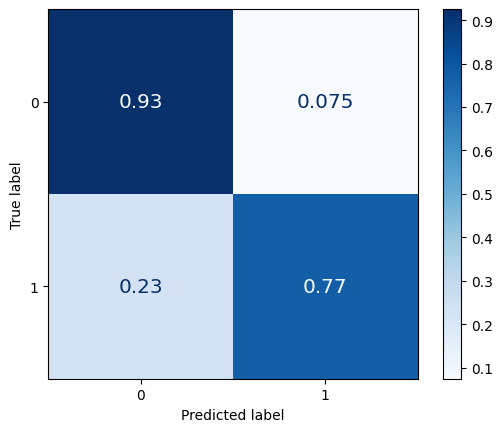

In [37]:
soft_pred = deepsad_soft.astype(float) + autonn_soft.astype(float) + tabnet_soft.astype(float) > 1.5
soft_disp = ConfusionMatrixDisplay.from_predictions(y_test['label'].to_numpy(), soft_pred, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'})

In [38]:
print(accuracy_score(y_test['label'].to_numpy(), soft_pred))
print(precision_score(y_test['label'].to_numpy(), soft_pred))
print(recall_score(y_test['label'].to_numpy(), soft_pred))
print(f1_score(y_test['label'].to_numpy(), soft_pred))
print(geometric_mean_score(y_test['label'].to_numpy(), soft_pred))

0.9118449700994059
0.5002775431398576
0.7715412960136971
0.6069807619103395
0.8449859453074824


In [39]:
def get_threshold(y_true, y_pred, target_tpr):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    index = np.argmin(np.abs(tpr - target_tpr))
    return threshold[index]

In [40]:
deepsad_threshold_09990 = get_threshold(y_test['label'].to_numpy(), deepsad_soft, 0.9990)
deepsad_threshold_09950 = get_threshold(y_test['label'].to_numpy(), deepsad_soft, 0.9950)
deepsad_threshold_09900 = get_threshold(y_test['label'].to_numpy(), deepsad_soft, 0.9900)
deepsad_threshold_09800 = get_threshold(y_test['label'].to_numpy(), deepsad_soft, 0.9800)
deepsad_threshold_09700 = get_threshold(y_test['label'].to_numpy(), deepsad_soft, 0.9700)

In [41]:
autonn_threshold_09990 = get_threshold(an_df['Predicted Label'].to_numpy(), autonn_soft, 0.9990)
autonn_threshold_09950 = get_threshold(an_df['Predicted Label'].to_numpy(), autonn_soft, 0.9950)
autonn_threshold_09900 = get_threshold(an_df['Predicted Label'].to_numpy(), autonn_soft, 0.9900)
autonn_threshold_09800 = get_threshold(an_df['Predicted Label'].to_numpy(), autonn_soft, 0.9800)
autonn_threshold_09700 = get_threshold(an_df['Predicted Label'].to_numpy(), autonn_soft, 0.9700)

In [42]:
tabnet_threshold_09990 = get_threshold(tabnet_model.y_test.to_numpy(), tabnet_soft, 0.9990)
tabnet_threshold_09950 = get_threshold(tabnet_model.y_test.to_numpy(), tabnet_soft, 0.9950)
tabnet_threshold_09900 = get_threshold(tabnet_model.y_test.to_numpy(), tabnet_soft, 0.9900)
tabnet_threshold_09800 = get_threshold(tabnet_model.y_test.to_numpy(), tabnet_soft, 0.9800)
tabnet_threshold_09700 = get_threshold(tabnet_model.y_test.to_numpy(), tabnet_soft, 0.9700)

In [43]:
def get_recall(y_true, y_pred, threshold):
    matrix = confusion_matrix(y_true, y_pred > threshold)
    return matrix[1][1] / (matrix[0][1] + matrix[1][1])

In [44]:
deepsad_hard = (deepsad_soft > deepsad_threshold_09900).astype(int)
autonn_hard = (autonn_soft > autonn_threshold_09900).astype(int)
tabnet_hard = (tabnet_soft > tabnet_threshold_09900).astype(int)

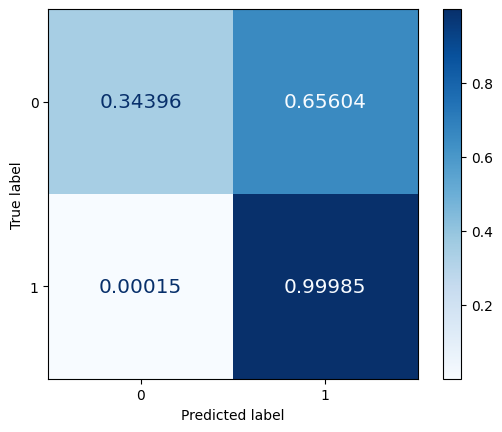

In [45]:
deepsad_hard = (deepsad_soft > deepsad_threshold_09990).astype(int)
autonn_hard = (autonn_soft > autonn_threshold_09990).astype(int)
tabnet_hard = (tabnet_soft > tabnet_threshold_09990).astype(int)
or_pred_09990 = (np.stack([deepsad_hard, autonn_hard, tabnet_hard]).sum(axis = 0) != 0).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test['label'].to_numpy(), or_pred_09990, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'}, values_format = '.5f')

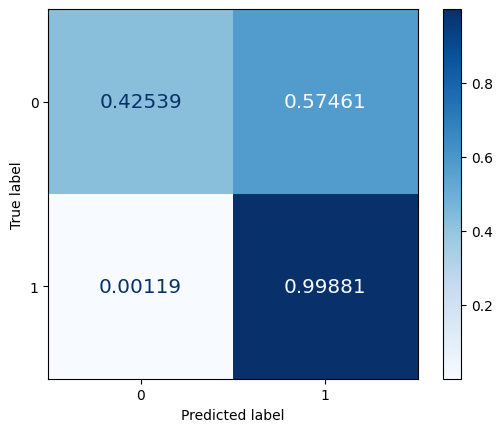

In [46]:
deepsad_hard = (deepsad_soft > deepsad_threshold_09950).astype(int)
autonn_hard = (autonn_soft > autonn_threshold_09950).astype(int)
tabnet_hard = (tabnet_soft > tabnet_threshold_09950).astype(int)
or_pred_09950 = (np.stack([deepsad_hard, autonn_hard, tabnet_hard]).sum(axis = 0) != 0).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test['label'].to_numpy(), or_pred_09950, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'}, values_format = '.5f')

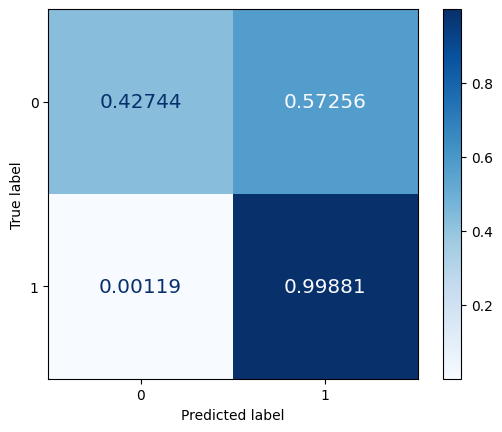

In [47]:
deepsad_hard = (deepsad_soft > deepsad_threshold_09900).astype(int)
autonn_hard = (autonn_soft > autonn_threshold_09900).astype(int)
tabnet_hard = (tabnet_soft > tabnet_threshold_09900).astype(int)
or_pred_09900 = (np.stack([deepsad_hard, autonn_hard, tabnet_hard]).sum(axis = 0) != 0).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test['label'].to_numpy(), or_pred_09900, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'}, values_format = '.5f')

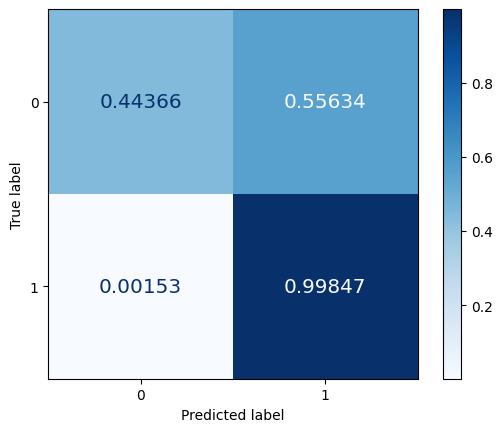

In [48]:
deepsad_hard = (deepsad_soft > deepsad_threshold_09800).astype(int)
autonn_hard = (autonn_soft > autonn_threshold_09800).astype(int)
tabnet_hard = (tabnet_soft > tabnet_threshold_09800).astype(int)
or_pred_09800 = (np.stack([deepsad_hard, autonn_hard, tabnet_hard]).sum(axis = 0) != 0).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test['label'].to_numpy(), or_pred_09800, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'}, values_format = '.5f')

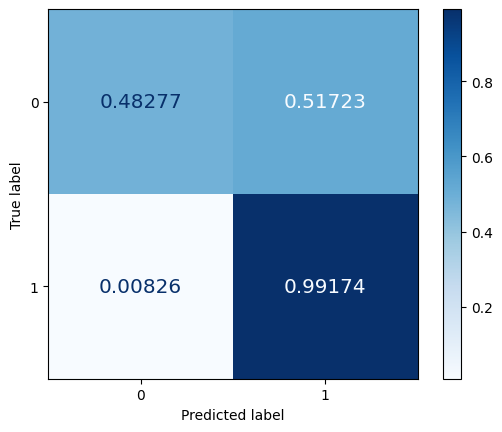

In [49]:
deepsad_hard = (deepsad_soft > deepsad_threshold_09700).astype(int)
autonn_hard = (autonn_soft > autonn_threshold_09700).astype(int)
tabnet_hard = (tabnet_soft > tabnet_threshold_09700).astype(int)
or_pred_09700 = (np.stack([deepsad_hard, autonn_hard, tabnet_hard]).sum(axis = 0) != 0).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test['label'].to_numpy(), or_pred_09700, normalize = 'true', cmap = plt.cm.Blues, text_kw = {'fontsize': 'x-large'}, values_format = '.5f')

In [50]:
deepsad_soft

array([0.45596915, 0.09060614, 0.04141763, ..., 0.04692025, 0.55158019,
       1.28543842])

In [51]:
x = np.linspace(0.999, 0.90, 100)
deepsad_ratio = []
autonn_ratio = []
tabnet_ratio = []
majority_ratio = []
or_ratio = []
soft_ratio = []

for threshold in tqdm(x):
    deepsad_threshold = get_threshold(y_test['label'].to_numpy(), deepsad_soft, threshold)
    autonn_threshold = get_threshold(an_df['Predicted Label'].to_numpy(), autonn_soft, threshold)
    tabnet_threshold = get_threshold(tabnet_model.y_test.to_numpy(), tabnet_soft, threshold)

    deepsad_hard = (deepsad_soft > deepsad_threshold).astype(int)
    autonn_hard = (autonn_soft > autonn_threshold).astype(int)
    tabnet_hard = (tabnet_soft > tabnet_threshold).astype(int)

    majority_pred = (np.stack([deepsad_hard, autonn_hard, tabnet_hard]).sum(axis = 0) > 1.5).astype(int)
    or_pred = (np.stack([deepsad_hard, autonn_hard, tabnet_hard]).sum(axis = 0) != 0).astype(int)
    soft_pred = (np.stack([deepsad_soft, autonn_soft, tabnet_soft]).sum(axis = 0) > deepsad_threshold + autonn_threshold + tabnet_threshold).astype(int)

    matrix = confusion_matrix(y_test['label'].to_numpy(), deepsad_hard)
    deepsad_ratio.append(matrix[0][1] / (matrix[0][0] + matrix[0][1]))

    matrix = confusion_matrix(y_test['label'].to_numpy(), autonn_hard)
    autonn_ratio.append(matrix[0][1] / (matrix[0][0] + matrix[0][1]))

    matrix = confusion_matrix(y_test['label'].to_numpy(), tabnet_hard)
    tabnet_ratio.append(matrix[0][1] / (matrix[0][0] + matrix[0][1]))

    matrix = confusion_matrix(y_test['label'].to_numpy(), majority_pred)
    majority_ratio.append(matrix[0][1] / (matrix[0][0] + matrix[0][1]))

    matrix = confusion_matrix(y_test['label'].to_numpy(), or_pred)
    or_ratio.append(matrix[0][1] / (matrix[0][0] + matrix[0][1]))

    matrix = confusion_matrix(y_test['label'].to_numpy(), soft_pred)
    soft_ratio.append(matrix[0][1] / (matrix[0][0] + matrix[0][1]))

100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


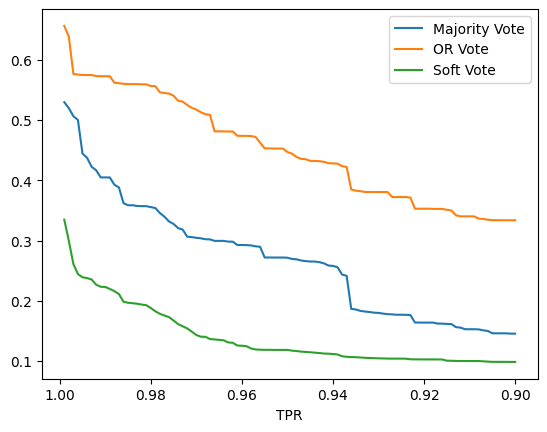

In [56]:
# plt.plot(np.linspace(0.999, 0.90, 100), deepsad_ratio, label = 'DeepSAD')
# plt.plot(np.linspace(0.999, 0.90, 100), autonn_ratio, label = 'Autoencoder + MLP')
# plt.plot(np.linspace(0.999, 0.90, 100), tabnet_ratio, label = 'TabNet')
plt.plot(np.linspace(0.999, 0.90, 100), majority_ratio, label = 'Majority Vote')
plt.plot(np.linspace(0.999, 0.90, 100), or_ratio, label = 'OR Vote')
plt.plot(np.linspace(0.999, 0.90, 100), soft_ratio, label = 'Soft Vote')

plt.xlabel('TPR')
plt.gca().invert_xaxis()
plt.legend()

plt.show()

In [61]:
prohibit_ratio = soft_ratio
danger_ratio = [x - y for x, y in zip(majority_ratio, soft_ratio)]
caution_ratio = [x - y for x, y in zip(or_ratio, majority_ratio)]
normal_ratio = [1 - x for x in or_ratio]

In [64]:
elapsed_time = [n * 1 + c * 3 + d * 5 + p * 10 for n, c, d, p in zip(normal_ratio, caution_ratio, danger_ratio, prohibit_ratio)]

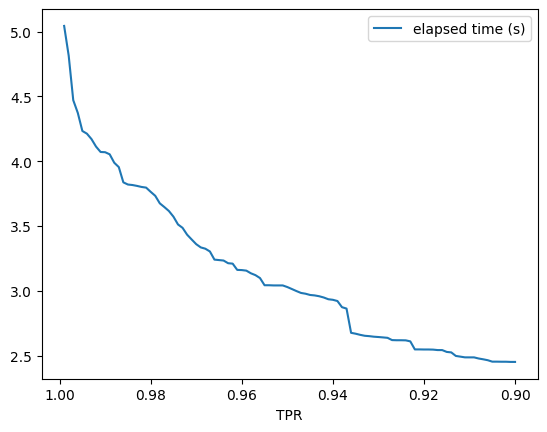

In [67]:
plt.plot(np.linspace(0.999, 0.90, 100), elapsed_time, label = 'elapsed time (s)')

plt.xlabel('TPR')
plt.gca().invert_xaxis()
plt.legend()

plt.show()

In [93]:
np.where(np.linspace(0.999, 0.90, 100) == 0.9990)

(array([0]),)

In [94]:
elapsed_time[0]

5.043455240921762

In [95]:
prohibit_ratio[0]

0.3344774925983821